# Berlinweite Kita-Versorgungsanalyse – Datenaufbereitung und Bewertung

Dieses Notebook ist Teil des Projekts **"KitaVision Berlin"** und behandelt die vollständige Datenverarbeitung sowie die Analyse der Kita-Versorgungssituation in den Berliner Bezirken. Hierbei werden verschiedene räumliche und statistische Daten zusammengeführt, um einen möglichst umfassenden Überblick über die aktuelle und zukünftige Betreuungssituation zu erhalten.

## Kernaufgaben des Notebooks:

1. **Datenintegration**  
   - Einlesen der Berliner Bezirksdaten über einen Web Feature Service (WFS)  
   - Import und Sichtprüfung der Kita-Daten (z. B. OSM-basierte Angaben zu Standorten und Kapazitäten)  
   - Zusammenführung mit Prognosedaten zu Kinderzahlen (0–6 Jahre) für die Jahre 2024, 2029, 2034 und 2039

2. **Kita-Statistiken und Versorgungsberechnung**  
   - Ermittlung der **Anzahl** der Kitas und **Gesamtkapazität** pro Bezirk  
   - Berechnung von **Versorgungsgraden** anhand der prognostizierten Kinderzahlen, um abzuschätzen, inwieweit die bestehenden Plätze den zukünftigen Bedarf decken

3. **Räumliche Analysen**  
   - Verschneidung der Bezirksgeometrien mit zusätzlichen **Isochronen**, **Natur-** und **Wasserflächen**, um die prozentuale **Abdeckung** pro Bezirk zu bestimmen  
   - Identifikation unterschiedlicher Versorgungslagen in Bezug auf Erreichbarkeit und räumliche Besonderheiten

4. **Kategorisierung und Trendbetrachtung**  
   - Einteilung der Bezirke in Kategorien (z. B. *optimal versorgt*, *gut versorgt*, *unterversorgt* etc.)  
   - Darstellung von **Trend**-Veränderungen zwischen 2024 und 2039, um Regionen mit erwarteter Verbesserung oder Verschlechterung hervorzuheben

5. **Datenausgabe und Visualisierung**  
   - Export der finalen Daten im **GeoJSON**-Format für die weitere Verarbeitung und Darstellung in GIS-Anwendungen  
   - Erzeugung von Diagrammen und Karten zur Veranschaulichung der Ergebnisse


In [2]:

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

KITAS_INPUT = Path("../data/processed/kitas_processed.geojson")
FORECAST_INPUT = Path("../data/processed/prognose_2024_2034.csv")
WFS_URL = "https://gdi.berlin.de/services/wfs/alkis_bezirke?REQUEST=GetCapabilities&SERVICE=wfs"
ISOCHRONE_INPUT = Path("../catchment_area/output/isochrones.geojson")
NATURE_INPUT =  Path("../catchment_area/output/berlin_green_areas.geojson")
WATER_INPUT = Path("../catchment_area/output/berlin_water_areas.geojson")
PROJECT_CRS = "EPSG:32633"  # Coordinate Reference System (CRS) for UTM Zone 33N, suitable for Germany

## Datenimport und erste Sichtprüfung

In diesem Abschnitt werden die relevanten Datensätze aus verschiedenen Quellen eingelesen, um eine solide Grundlage für die weiteren Analysen zu schaffen:

1. **Bezirksdaten**  
   - Über einen WFS (Web Feature Service) werden die Geodaten der Berliner Bezirke importiert.  
   - Eine kurze Vorschau zeigt die ersten Zeilen der Daten und listet die vorhandenen Spalten auf, um sich einen Überblick über den Aufbau der Geodaten zu verschaffen.

2. **Kita-Daten**  
   - Anschließend werden die Kita-Standorte als Geodaten eingelesen.  
   - Neben einer stichprobenartigen Sichtung (head) wird auch die Gesamtanzahl der Kita-Standorte ausgegeben.  
   - Die Spaltenübersicht verdeutlicht, welche Informationen pro Kita verfügbar sind.

3. **Prognosedaten**  
   - Zum Schluss werden die prognostizierten Kinderzahlen (bis 2039) geladen und transponiert, um eine geeignete Tabellenstruktur für weitere Auswertungen zu erhalten.  
   - Ein Blick auf die Spalten zeigt, wie die Prognosewerte für die einzelnen Bezirke gespeichert sind.

Diese erste Sichtprüfung unterstützt dabei, die Datenqualität zu beurteilen und einen Eindruck von Umfang und Aufbau der Datensätze zu gewinnen.


In [3]:
# Load district data
print("District data:")
berlin_districts = gpd.read_file(WFS_URL)
display(berlin_districts.head(2))
print("\nColumns:", berlin_districts.columns.tolist())

# Load daycare data
print("\nDaycare data:")
kitas = gpd.read_file(KITAS_INPUT)
display(kitas.head(2))
print(f"\nNumber of daycare locations: {len(kitas)}")
print("Columns:", kitas.columns.tolist())

# Load forecast data
print("\nForecast data:")
forecast = pd.read_csv(FORECAST_INPUT, index_col=0)
forecast_transposed = forecast.T
display(forecast_transposed.head(2))
print("\nColumns:", forecast_transposed.columns.tolist())

District data:


,gml_id,objectid,lan,namlan,gem,namgem,name,geometry
0,bezirksgrenzen.1,1,11,Berlin,003,Pankow,11000003,"MULTIPOLYGON (((399003.49 5834202.526, 398981...."
1,bezirksgrenzen.2,2,11,Berlin,004,Charlottenburg-Wilmersdorf,11000004,"MULTIPOLYGON (((387115.47 5816898.439, 387126...."



Columns: ['gml_id', 'objectid', 'lan', 'namlan', 'gem', 'namgem', 'name', 'geometry']

Daycare data:


,name,id,suburb,final_capacity,capacity_source,geometry
0,Nestwärme Kita,node/167048488,Friedrichshain-Kreuzberg,63.0,predicted,POINT (393661.454 5817976.342)
1,Kita Fehlerstraße 2,node/268915158,Tempelhof-Schöneberg,89.0,predicted,POINT (386296.067 5815382.547)



Number of daycare locations: 2334
Columns: ['name', 'id', 'suburb', 'final_capacity', 'capacity_source', 'geometry']

Forecast data:


Bezirk,Mitte,Friedrichshain-Kreuzberg,Pankow,Charlottenburg-Wilmersdorf,Spandau,Steglitz-Zehlendorf,Tempelhof-Schöneberg,Neukölln,Treptow-Köpenick,Marzahn-Hellersdorf,Lichtenberg,Reinickendorf
2024,21130,15504,23466,16288,15312,14349,19281,18317,17140,17784,19646,15157
2029,19191,15208,19984,16524,15959,12886,18613,16965,17547,18866,19144,14804



Columns: ['Mitte', 'Friedrichshain-Kreuzberg', 'Pankow', 'Charlottenburg-Wilmersdorf', 'Spandau', 'Steglitz-Zehlendorf', 'Tempelhof-Schöneberg', 'Neukölln', 'Treptow-Köpenick', 'Marzahn-Hellersdorf', 'Lichtenberg', 'Reinickendorf']


## Berechnung zusammenfassender Kennzahlen pro Bezirk

In diesem Abschnitt werden die eingelesenen Kita-Daten nach Bezirk gruppiert und grundlegende Kennzahlen ermittelt:

1. **Gruppierung und Aggregation**  
   - Die Kitas werden anhand der Spalte *suburb* (Bezirk) zusammengefasst.  
   - Für jeden Bezirk wird die **Anzahl** der Kitas sowie die **Summe** der Kita-Kapazitäten berechnet.

2. **Datenaufbereitung**  
   - Zur besseren Lesbarkeit werden die Spalten umbenannt (z. B. *suburb* → *Bezirk*).  
   - Die Kapazitätswerte werden in Ganzzahlen konvertiert, um eine einheitliche Darstellung zu gewährleisten.

3. **Bereinigung und Sortierung**  
   - Einträge mit dem Bezirk *Unbekannt* werden ausgeschlossen.  
   - Das Ergebnis wird absteigend nach der Anzahl der Kitas sortiert, um Bezirke mit besonders vielen Kitas schnell zu identifizieren.

Diese aggregierten Kennzahlen bieten einen ersten Überblick darüber, wie sich die Kitas im Berliner Stadtgebiet verteilen und welche Bezirke besonders hohe oder niedrige Betreuungskapazitäten aufweisen.


In [4]:
# Grouping and calculating statistics
kita_stats = (kitas.groupby('suburb')
            .agg({
                'name': 'count',  # Number of daycare centers per district
                'final_capacity': 'sum'  # Sum of capacities per district
            })
            .reset_index())

# Renaming columns
kita_stats = kita_stats.rename(columns={
    'suburb': 'Bezirk', 
    'name': 'Anzahl Kitas',
    'final_capacity': 'Gesamtkapazität'
})

# Integer capacity
kita_stats['Gesamtkapazität'] = kita_stats['Gesamtkapazität'].astype(int)

# Removing "Unbekannt" and sorting by number of daycare centers
kita_stats = (kita_stats[kita_stats['Bezirk'] != 'Unbekannt']
                .sort_values('Anzahl Kitas', ascending=False))

# Preview of the calculated statistics
print("Calculated daycare center statistics per district:")
display(kita_stats)

Calculated daycare center statistics per district:


,Bezirk,Anzahl Kitas,Gesamtkapazität
6,Pankow,289,21636
10,Tempelhof-Schöneberg,275,23251
4,Mitte,257,22961
1,Friedrichshain-Kreuzberg,228,16383
0,Charlottenburg-Wilmersdorf,217,13289
9,Steglitz-Zehlendorf,192,16662
5,Neukölln,171,15980
11,Treptow-Köpenick,162,15705
7,Reinickendorf,158,13894
2,Lichtenberg,150,17236


## Visualisierung der Kita-Statistiken pro Bezirk

In diesem Schritt werden die Bezirksdaten anhand zweier Merkmale untersucht:

1. **Sortierung nach Anzahl Kitas**  
   - Zunächst wird die Tabelle nach der Spalte *Anzahl Kitas* aufsteigend sortiert. 
   - Anschließend zeigt ein Balkendiagramm, welche Bezirke die wenigsten und welche die meisten Kitas beherbergen.

2. **Sortierung nach Gesamtkapazität**  
   - Zusätzlich wird die Tabelle nach der *Gesamtkapazität* sortiert, um Bezirke mit geringem bzw. hohem Angebot an Betreuungsplätzen zu identifizieren.
   - Auch hier veranschaulicht ein Balkendiagramm die Verteilung der Gesamtkapazitäten zwischen den Bezirken.

Durch die Kombination beider Darstellungen wird deutlich, in welchen Bezirken viele kleine oder wenige große Kitas existieren und wo ggf. eine bessere Abdeckung der Nachfrage erforderlich ist.


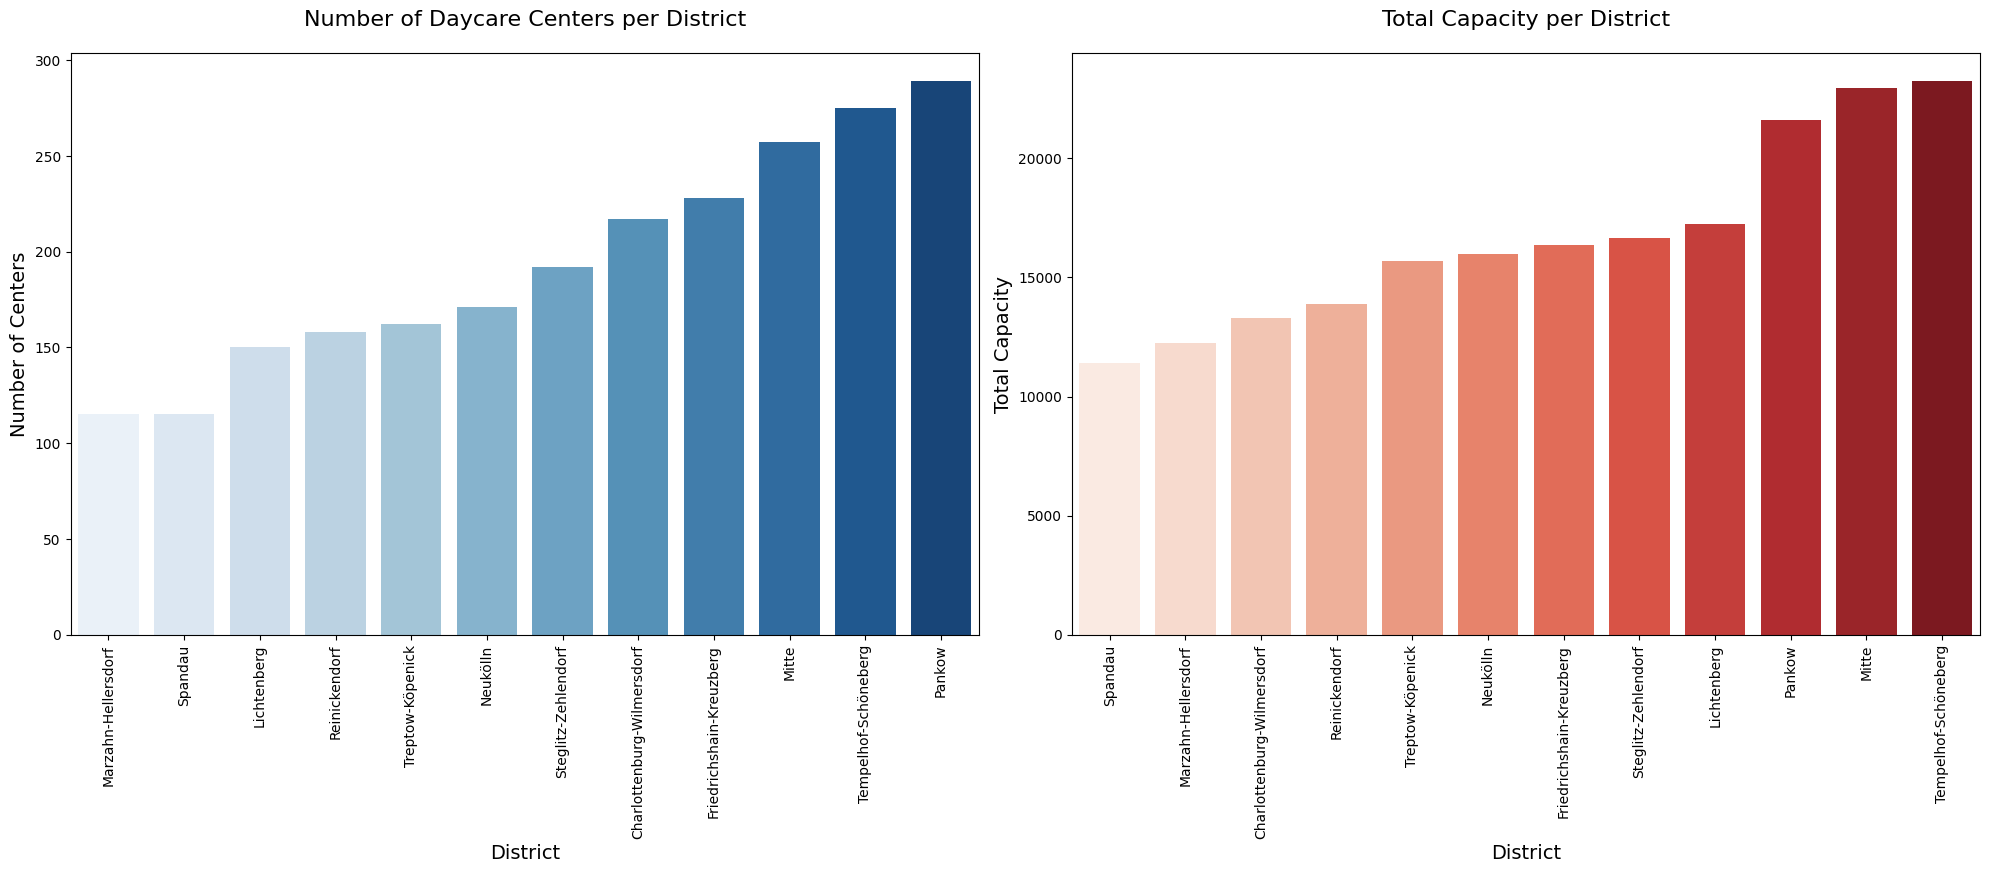

In [5]:
# Sorting data by 'Number of Daycare Centers' and 'Total Capacity' in ascending order
kita_stats_sorted_kitas = kita_stats.sort_values(by='Anzahl Kitas', ascending=True)
kita_stats_sorted_capacity = kita_stats.sort_values(by='Gesamtkapazität', ascending=True)

# Creating the figure with more height to accommodate labels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Number of daycare centers per district (sorted)
sns.barplot(
    data=kita_stats_sorted_kitas, 
    x='Bezirk', 
    y='Anzahl Kitas', 
    hue='Bezirk',
    dodge=False,
    ax=ax1, 
    palette=sns.color_palette("Blues", n_colors=len(kita_stats_sorted_kitas['Bezirk'].unique())),
    errorbar=None,
    legend=False
)
ax1.set_title('Number of Daycare Centers per District', fontsize=16, pad=20)
ax1.set_xlabel('District', fontsize=14)
ax1.set_ylabel('Number of Centers', fontsize=14)

# Rotate labels and adjust their position
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)  # Vertical labels
ax1.tick_params(axis='y', labelsize=10)

# Total capacity per district (sorted)
sns.barplot(
    data=kita_stats_sorted_capacity, 
    x='Bezirk', 
    y='Gesamtkapazität', 
    hue='Bezirk',
    dodge=False,
    ax=ax2, 
    palette=sns.color_palette("Reds", n_colors=len(kita_stats_sorted_capacity['Bezirk'].unique())),
    errorbar=None,
    legend=False
)
ax2.set_title('Total Capacity per District', fontsize=16, pad=20)
ax2.set_xlabel('District', fontsize=14)
ax2.set_ylabel('Total Capacity', fontsize=14)

# Rotate labels and adjust their position
ax2.tick_params(axis='x', labelrotation=90, labelsize=10)  # Vertical labels
ax2.tick_params(axis='y', labelsize=10)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add more bottom margin
plt.subplots_adjust(bottom=0.2)

plt.show()

## Zusammenführung und Aufbereitung aller Daten

1. **Merge von Bezirks- und Kita-Statistiken**  
   - Die zuvor berechneten Kita-Statistiken pro Bezirk werden mittels eines Joins (merge) an die Geodaten der Berliner Bezirke angefügt.  
   - Dieses Ergebnis enthält für jeden Bezirk nun sowohl die räumlichen Informationen als auch die Kennzahlen zur Anzahl der Kitas und zur Gesamtkapazität.

2. **Vorbereitung der Prognosedaten**  
   - Die Spalten der importierten Prognosedaten werden umbenannt, um aussagekräftigere Bezeichnungen wie *Prognose_2024* oder *Prognose_2039* zu erhalten.

3. **Finaler Merge**  
   - Anschließend werden die Prognosedaten über einen weiteren Join hinzugefügt, sodass pro Bezirk die prognostizierten Kinderzahlen für verschiedene Zieljahre integriert sind.  
   - Die Kombination aller Quellen (Bezirksgeometrien, Kita-Statistiken, Prognosen) ermöglicht eine ganzheitliche Analyse im Geodatenformat.

4. **Strukturierung der Ergebnisdaten**  
   - Relevante Spalten (z. B. *Bezirk*, *Anzahl Kitas*, *Prognose_2029*) werden ausgewählt und in eine übersichtliche Reihenfolge gebracht.  
   - Die entstandene Geodatenstruktur **final_districts** bietet einen vollständigen Überblick über Kitas, Kapazitäten und zukünftige Kinderzahlen je Bezirk.

Ein erster Blick auf die kombinierten Daten (z. B. mit `head()`) zeigt die erfolgreiche Verknüpfung aller Informationen.


In [6]:
# Merge Kita statistics with district data
districts_with_stats = gpd.GeoDataFrame(
    berlin_districts.merge(
        kita_stats,
        left_on='namgem', 
        right_on='Bezirk',
        how='left'
    ),
    geometry='geometry',
    crs=PROJECT_CRS
)

# Prepare forecast data
# Rename columns from years to more descriptive names
forecast_renamed = forecast.rename(columns={
    '2024': 'Prognose_2024',
    '2029': 'Prognose_2029',
    '2034': 'Prognose_2034'
})

# Final merge of all data
# Convert the result back to GeoDataFrame after merge
districts_with_all = gpd.GeoDataFrame(
    districts_with_stats.merge(
        forecast_renamed,
        left_on='namgem',
        right_index=True,
        how='left'
    ),
    geometry='geometry',
    crs=PROJECT_CRS
)

# Select relevant columns and reorder
final_districts = gpd.GeoDataFrame(
    districts_with_all[[
        'namgem',
        'Anzahl Kitas',
        'Gesamtkapazität',
        'Prognose_2024',
        'Prognose_2029',
        'Prognose_2034',
        'geometry'
    ]].rename(columns={'namgem': 'Bezirk'}),
    geometry='geometry',
    crs=PROJECT_CRS
)

# Output the data
print("\nOverview of merged data:")
display(final_districts[['Bezirk', 'Anzahl Kitas', 'Gesamtkapazität', 'Prognose_2024', 'Prognose_2029']].head())

print("\nAvailable columns:")
for col in final_districts.columns:
    print(f"- {col}")


Overview of merged data:


,Bezirk,Anzahl Kitas,Gesamtkapazität,Prognose_2024,Prognose_2029
0,Pankow,289,21636,23466,19984
1,Charlottenburg-Wilmersdorf,217,13289,16288,16524
2,Marzahn-Hellersdorf,115,12251,17784,18866
3,Friedrichshain-Kreuzberg,228,16383,15504,15208
4,Reinickendorf,158,13894,15157,14804



Available columns:
- Bezirk
- Anzahl Kitas
- Gesamtkapazität
- Prognose_2024
- Prognose_2029
- Prognose_2034
- geometry


## Erreichbarkeitsanalyse: Verschneidung und Abdeckungsanalyse

In diesem Abschnitt werden zusätzliche Geodaten (Isochronen, Natur- und Wasserflächen) eingelesen und zu einem einheitlichen Datensatz zusammengefasst, um deren räumliche Überlagerung mit den Berliner Bezirken zu untersuchen:

1. **Zusätzliche Geo-Datensätze laden**  
   - Isochronen, Natur- und Wasserflächen werden jeweils als eigenes GeoDataFrame importiert.  
   - Diese Flächen können wertvolle Hinweise auf Erreichbarkeitsstrukturen sowie naturräumliche Gegebenheiten geben.

2. **Union der Geometrien**  
   - Alle Geometrien (Isochronen, Natur- und Wasserflächen) werden in einer **GeoSeries** zusammengeführt und mithilfe der Methode `.union_all()` zu einer einzigen Geometrie vereinigt.  
   - Dadurch entsteht ein **GeoDataFrame**, das alle interessierenden Flächen zusammengefasst enthält.

3. **Coordinate Reference System (CRS)**  
   - Gegebenenfalls erfolgt eine Transformation in das Koordinatensystem der Bezirksdaten, um eine korrekte räumliche Analyse sicherzustellen.  
   - Nur wenn beide Datensätze dasselbe CRS verwenden, können Flächen zuverlässig berechnet werden.

4. **Flächenberechnung je Bezirk**  
   - Für jeden Bezirk wird die Schnittmenge (*Intersection*) mit der vereinigten Gesamtgeometrie gebildet.  
   - Anschließend wird der Flächenanteil der Schnittmenge in Relation zur gesamten Bezirksfläche gesetzt, sodass ein prozentualer Wert (*Abdeckung*) entsteht.

5. **Ergebnisintegration**  
   - Die berechnete Abdeckung wird als neue Spalte **Abdeckung** dem DataFrame *final_districts* hinzugefügt und auf zwei Nachkommastellen gerundet.  
   - Eine abschließende Sortierung zeigt Bezirke mit hoher bzw. niedriger Abdeckung nach oben bzw. unten.

Diese Analyse liefert Einblicke, wie stark die Bezirksflächen von den erfassten Isochronen, Natur- und Wasserflächen überlagert sind. Die ermittelten Abdeckungswerte können beispielsweise für Erreichbarkeits- oder Umweltanalysen weiterverwendet werden.


In [8]:
# Load additional geospatial data
isochrones = gpd.read_file(ISOCHRONE_INPUT)
nature_area = gpd.read_file(NATURE_INPUT)
water_area = gpd.read_file(WATER_INPUT)
    
# Create a GeoSeries with CRS for all geometries
all_geometries = gpd.GeoSeries(
    list(isochrones.geometry) + 
    list(nature_area.geometry) + 
    list(water_area.geometry),
    crs=isochrones.crs
)

# Union as GeoDataFrame
united_gdf = gpd.GeoDataFrame(geometry=[all_geometries.union_all()], crs=isochrones.crs)

# CRS transformation if necessary
if final_districts.crs != united_gdf.crs:
    united_gdf = united_gdf.to_crs(final_districts.crs)

# List for the results
coverage_percentages = []

# Calculation for each district
for idx, row in final_districts.iterrows():
    # Intersection between district and isochrones
    intersection = row.geometry.intersection(united_gdf.geometry.iloc[0])
    # Calculation of the percentage share
    coverage_percentage = (intersection.area / row.geometry.area) * 100
    coverage_percentages.append(coverage_percentage)

# Add coverage to the DataFrame
final_districts['Abdeckung'] = coverage_percentages
final_districts['Abdeckung'] = final_districts['Abdeckung'].round(2)

# Output of the results
print("\n📦 Kita coverage by districts (in %):")
display(final_districts[['Bezirk', 'Abdeckung']].sort_values('Abdeckung', ascending=False))


📦 Kita coverage by districts (in %):


,Bezirk,Abdeckung
3,Friedrichshain-Kreuzberg,98.74
11,Mitte,92.04
9,Steglitz-Zehlendorf,87.12
1,Charlottenburg-Wilmersdorf,85.56
7,Treptow-Köpenick,83.40
4,Reinickendorf,82.60
10,Neukölln,81.19
5,Tempelhof-Schöneberg,80.07
6,Lichtenberg,76.52
8,Spandau,73.34


## Erweiterte Versorgungsanalyse und Trendbetrachtung

In diesem Schritt wird die Versorgungssituation der Bezirke weiter verfeinert, indem für mehrere Zieljahre jeweils **Versorgungsgrade** und zugehörige **Kategorien** berechnet werden. Zusätzlich erfolgt eine **Trendbetrachtung** von 2024 bis 2039:

1. **Versorgungsgrade für 2024, 2029, 2034, 2039**  
   - Der Versorgungsgrad ergibt sich aus dem Verhältnis von *Gesamtkapazität* zu *Prognosejahr* in Prozent.  
   - Damit lässt sich ablesen, wie viele Kita-Plätze im Verhältnis zur prognostizierten Kinderzahl tatsächlich vorhanden sind.

2. **Kategorisierung**  
   - Für 2024 und 2034 werden die Bezirke anhand ihres Versorgungsgrades und ihrer **Abdeckung** in fünf Kategorien eingeteilt: 
     1. *Optimal versorgt*  
     2. *Gut versorgt*  
     3. *Ausreichend versorgt*  
     4. *Unterversorgt*  
     5. *Kritisch unterversorgt*
   - Die Zuordnung erfolgt über Schwellwerte für den Versorgungsgrad und die Abdeckung.  

3. **Trendberechnung (2024 → 2039)**  
   - Die Differenz zwischen dem Versorgungsgrad 2024 und dem Versorgungsgrad 2039 liefert die *Entwicklung_2024_2039*.  
   - Eine Änderung von mehr als ±5 Prozentpunkten wird als *Verbesserung* oder *Verschlechterung* klassifiziert, während geringere Veränderungen als *stabil* gewertet werden.

Durch diese erweiterte Analyse können bestehende Versorgungslücken sowohl aktuell als auch im zukünftigen Verlauf identifiziert werden. Die abschließende Tabelle fasst alle relevanten Kennzahlen (Versorgungsgrade, Kategorie, Entwicklung und Trend) zusammen und bildet damit eine solide Basis für Planung und Entscheidung im Berliner Kita-Bereich.


In [11]:
# Calculate coverage rates for all years
for jahr in [2024, 2029, 2034]:
    final_districts[f'Versorgungsgrad_{jahr}'] = (
        final_districts['Gesamtkapazität'] / final_districts[f'Prognose_{jahr}'] * 100
    ).round(2)
    
# Categorization with German labels
kategorie_mapping = {
    'Optimal versorgt': lambda row: row['Versorgungsgrad_2024'] >= 95 and row['Abdeckung'] >= 80,
    'Gut versorgt': lambda row: row['Versorgungsgrad_2024'] >= 85 and row['Abdeckung'] >= 70,
    'Schlecht versorgt': lambda row: row['Versorgungsgrad_2024'] >= 75 and row['Abdeckung'] >= 60,
    'Unterversorgt': lambda row: row['Versorgungsgrad_2024'] >= 65,
    'Kritisch unterversorgt': lambda row: True  # Default case
}

kategorie_mapping_2034 = {
    'Optimal versorgt': lambda row: row['Versorgungsgrad_2034'] >= 95 and row['Abdeckung'] >= 80,
    'Gut versorgt': lambda row: row['Versorgungsgrad_2034'] >= 85 and row['Abdeckung'] >= 70,
    'Schlecht versorgt': lambda row: row['Versorgungsgrad_2034'] >= 75 and row['Abdeckung'] >= 60,
    'Unterversorgt': lambda row: row['Versorgungsgrad_2034'] >= 65,
    'Kritisch unterversorgt': lambda row: True  # Default case
}

# Categorization for 2024
final_districts['Kategorie_2024'] = final_districts.apply(
    lambda row: next(
        kategorie for kategorie, condition in kategorie_mapping.items() 
        if condition(row)
    ),
    axis=1
)

# Categorization for 2034
final_districts['Kategorie_2034'] = final_districts.apply(
    lambda row: next(
        kategorie for kategorie, condition in kategorie_mapping_2034.items() 
        if condition(row)
    ),
    axis=1
)

# Trend calculation (Change 2024 to 2034)
final_districts['Entwicklung_2024_2034'] = (
    final_districts['Versorgungsgrad_2034'] - final_districts['Versorgungsgrad_2024']
).round(2)

# Trend categorization with German labels
trend_mapping = {
    'Verbesserung': lambda x: x > 5,
    'Verschlechterung': lambda x: x < -5,
    'Stabil': lambda x: True  # Default case
}

# Trend categorization
final_districts['Trend_2024_2034'] = final_districts['Entwicklung_2024_2034'].apply(
    lambda x: next(
        trend for trend, condition in trend_mapping.items()
        if condition(x)
    )
)

# Output for verification
print("\n📊 Übersicht der Versorgungssituation:")
display(final_districts[[
    'Bezirk', 
    'Versorgungsgrad_2024',
    'Abdeckung',
    'Kategorie_2024',
    'Entwicklung_2024_2034',
    'Trend_2024_2034',
    'Kategorie_2034',
]].sort_values('Versorgungsgrad_2024', ascending=False))


📊 Übersicht der Versorgungssituation:


,Bezirk,Versorgungsgrad_2024,Abdeckung,Kategorie_2024,Entwicklung_2024_2034,Trend_2024_2034,Kategorie_2034
5,Tempelhof-Schöneberg,120.59,80.07,Optimal versorgt,11.17,Verbesserung,Optimal versorgt
9,Steglitz-Zehlendorf,116.12,87.12,Optimal versorgt,33.75,Verbesserung,Optimal versorgt
11,Mitte,108.67,92.04,Optimal versorgt,28.69,Verbesserung,Optimal versorgt
3,Friedrichshain-Kreuzberg,105.67,98.74,Optimal versorgt,10.06,Verbesserung,Optimal versorgt
0,Pankow,92.20,66.26,Schlecht versorgt,43.40,Verbesserung,Schlecht versorgt
4,Reinickendorf,91.67,82.60,Gut versorgt,5.05,Verbesserung,Optimal versorgt
7,Treptow-Köpenick,91.63,83.40,Gut versorgt,-3.45,Stabil,Gut versorgt
6,Lichtenberg,87.73,76.52,Gut versorgt,5.53,Verbesserung,Gut versorgt
10,Neukölln,87.24,81.19,Gut versorgt,16.82,Verbesserung,Optimal versorgt
1,Charlottenburg-Wilmersdorf,81.59,85.56,Schlecht versorgt,-0.50,Stabil,Schlecht versorgt


## Aufteilung und Export der Datensätze

Für eine flexible Weiterverarbeitung werden die zusammengeführten Bezirksdaten in mehrere Teilbestände untergliedert und anschließend als **GeoJSON**-Dateien abgespeichert:

1. **Basisdaten**  
   - *base_districts* enthält grundlegende Informationen wie **Bezirksnamen**, **Geometrie**, **Anzahl Kitas**, **Gesamtkapazität**, **Abdeckung** sowie die **Prognose** und den **Versorgungsgrad** für das Jahr 2024.

2. **Kategorisierung 2024**  
   - *kategorie_districts* filtert lediglich die Spalte **Kategorie**, welche Aufschluss über den aktuellen Versorgungsstatus der Bezirke gibt.

3. **Trendanalyse**  
   - *trend_districts* enthält die Klassifikation des Trends zwischen 2024 und 2039 in Form des **Trend**-Werts, der eine Verbesserung, Verschlechterung oder Stabilität anzeigt.

4. **Kategorisierung 2034**  
   - *kategorie_2034_districts* repräsentiert die Versorgungs-Kategorien auf Basis der Prognosewerte für das Jahr 2034.

Nach der Erstellung der einzelnen Datensätze werden diese mithilfe von **GeoPandas** im **GeoJSON**-Format gesichert. Dabei werden die Ausgabepfade im Dateisystem vorbereitet (z. B. durch das Anlegen fehlender Verzeichnisse) und anschließend die Dateien in die gewünschte Ordnerstruktur geschrieben.


In [15]:
# Define output directory and files
output_dir = Path("../data/final")
output_files = {
    'base': {
        'name': 'kita_versorgung_basis.geojson',
        'columns': [
            'Bezirk', 'geometry', 'Anzahl Kitas', 'Gesamtkapazität',
            'Abdeckung', 'Prognose_2024', 'Versorgungsgrad_2024'
        ]
    },
    'kategorie': {
        'name': 'kita_versorgung_kategorie_2024.geojson',
        'columns': ['Bezirk', 'geometry', 'Kategorie_2024']
    },
    'trend': {
        'name': 'kita_versorgung_trend_2024_2034.geojson',
        'columns': ['Bezirk', 'geometry', 'Trend_2024_2034']
    },
    'kategorie_2034': {
        'name': 'kita_versorgung_kategorie_2034.geojson',
        'columns': ['Bezirk', 'geometry', 'Kategorie_2034']
    }
}

# Create output directory
output_dir.mkdir(parents=True, exist_ok=True)

# Process and save each file
for key, file_info in output_files.items():
    # Create GeoDataFrame with selected columns
    gdf = gpd.GeoDataFrame(
        final_districts[file_info['columns']]
    ).to_crs('EPSG:4326')
    
    # Define output path
    output_path = output_dir / file_info['name']
    
    # Save to GeoJSON
    gdf.to_file(output_path, driver='GeoJSON')
    
    # Verify file creation and print info
    if output_path.exists():
        file_size = output_path.stat().st_size / 1024  # Convert to KB
        print(f"✅ {file_info['name']} created successfully")
        print(f"   📍 Size: {file_size:.1f} KB")
        print(f"   📍 Number of features: {len(gdf)}")
        print(f"   📍 Columns: {', '.join(gdf.columns)}\n")
    else:
        print(f"❌ Error creating {file_info['name']}")

✅ kita_versorgung_basis.geojson created successfully
   📍 Size: 1204.8 KB
   📍 Number of features: 12
   📍 Columns: Bezirk, geometry, Anzahl Kitas, Gesamtkapazität, Abdeckung, Prognose_2024, Versorgungsgrad_2024

✅ kita_versorgung_kategorie_2024.geojson created successfully
   📍 Size: 1203.8 KB
   📍 Number of features: 12
   📍 Columns: Bezirk, geometry, Kategorie_2024

✅ kita_versorgung_trend_2024_2034.geojson created successfully
   📍 Size: 1203.8 KB
   📍 Number of features: 12
   📍 Columns: Bezirk, geometry, Trend_2024_2034

✅ kita_versorgung_kategorie_2034.geojson created successfully
   📍 Size: 1203.8 KB
   📍 Number of features: 12
   📍 Columns: Bezirk, geometry, Kategorie_2034

